# Import library

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px 
import plotly.graph_objs as pgo 
from plotly.subplots import make_subplots

In [2]:
cid = ''
secret = ''

In [3]:
client_credential = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credential)

# Extract data from Spotify API

In [4]:
artist = []
track = []
popularity = []
track_id = []
release_date = []

for i in range(0, 1000, 50):
    result = sp.search(q='year:2020', type='track', limit=50, offset=i)
    for i, t in enumerate(result['tracks']['items']):
        artist.append(t['artists'][0]['name'])
        track.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
        release_date.append(t['album']['release_date'])

In [5]:
df_tracks = pd.DataFrame({
    'track_id': track_id,
    'artist': artist,
    'track': track,
    'popularity': popularity,
    'release_date': release_date
})

df_tracks

,track_id,artist,track,popularity,release_date
0,463CkQjx2Zk1yXoBuierM9,Dua Lipa,Levitating (feat. DaBaby),90,2020-10-01
1,51TAp7p7B3xboCl5HWmEkF,Hammock,Longest Year - 2020,26,2020-12-04
2,0VjIjW4GlUZAMYd2vXMi3b,The Weeknd,Blinding Lights,93,2020-03-20
3,457sndKohlwTU6dW6amBMU,Tame Impala,Alter Ego - 2020 Mix,52,2021-04-30
4,6tDDoYIxWvMLTdKpjFkc1B,Kali Uchis,telepatía,90,2020-12-04
...,...,...,...,...,...
995,4RfYytVLZVug49iuNMojuu,Ash,Shining Light - 2020 - Remaster,15,2020-02-14
996,2297mxrYLBAC4XkhXs39If,King Von,Armed & Dangerous,67,2020-10-30
997,11UjUHzsWmHc7YdNtnwaeT,Andrew Gold,Lonely Boy - 2020 Remaster,5,2020-10-02
998,7LE1K0lZyRFZjSlrnm7lfD,Jay Wheeler,"La Curiosidad (feat. Dj Nelson, Jhay Cortez, L...",78,2020-12-17


In [6]:
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   track_id      1000 non-null   object
 1   artist        1000 non-null   object
 2   track         1000 non-null   object
 3   popularity    1000 non-null   int64 
 4   release_date  1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


In [7]:
df_tracks['release_date'] = pd.to_datetime(df_tracks['release_date'])
df_tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   track_id      1000 non-null   object        
 1   artist        1000 non-null   object        
 2   track         1000 non-null   object        
 3   popularity    1000 non-null   int64         
 4   release_date  1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 39.2+ KB


# Data cleaning

In [8]:
group = df_tracks.groupby(['artist', 'track'], as_index=True).size()

group[group > 1].count()

21

In [9]:
df_tracks.drop_duplicates(subset=['artist', 'track'], inplace=True)

In [10]:
df_tracks[df_tracks.duplicated(subset=['artist', 'track'], keep=False)].count()

track_id        0
artist          0
track           0
popularity      0
release_date    0
dtype: int64

In [11]:
row = []
batchsize = 100
none_counter = 0

for i in range(0, len(df_tracks['track_id']), batchsize):
    batch = df_tracks['track_id'][i:i+batchsize]
    feature_result = sp.audio_features(batch)
    for i, t in enumerate(feature_result):
        if t == None:
            none_counter += 1
        else:
            row.append(t)

print(f'Number of track where no audio features: {none_counter}')

Number of track where no audio features: 0


In [12]:
print(len(row))

978


In [13]:
df_audio_feature = pd.DataFrame.from_dict(row, orient='columns')
df_audio_feature

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.7020,0.825,6,-3.787,0,0.0601,0.008830,0.000000,0.0674,0.9150,102.977,audio_features,463CkQjx2Zk1yXoBuierM9,spotify:track:463CkQjx2Zk1yXoBuierM9,https://api.spotify.com/v1/tracks/463CkQjx2Zk1...,https://api.spotify.com/v1/audio-analysis/463C...,203064,4
1,0.0692,0.285,2,-14.854,1,0.0482,0.700000,0.673000,0.1990,0.0312,78.572,audio_features,51TAp7p7B3xboCl5HWmEkF,spotify:track:51TAp7p7B3xboCl5HWmEkF,https://api.spotify.com/v1/tracks/51TAp7p7B3xb...,https://api.spotify.com/v1/audio-analysis/51TA...,533707,4
2,0.5140,0.730,1,-5.934,1,0.0598,0.001460,0.000095,0.0897,0.3340,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4
3,0.4080,0.903,0,-2.924,1,0.0561,0.002560,0.000821,0.1170,0.3680,128.942,audio_features,457sndKohlwTU6dW6amBMU,spotify:track:457sndKohlwTU6dW6amBMU,https://api.spotify.com/v1/tracks/457sndKohlwT...,https://api.spotify.com/v1/audio-analysis/457s...,289867,4
4,0.6530,0.524,11,-9.016,0,0.0502,0.112000,0.000000,0.2030,0.5530,83.970,audio_features,6tDDoYIxWvMLTdKpjFkc1B,spotify:track:6tDDoYIxWvMLTdKpjFkc1B,https://api.spotify.com/v1/tracks/6tDDoYIxWvML...,https://api.spotify.com/v1/audio-analysis/6tDD...,160191,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,0.4700,0.898,2,-5.001,1,0.0415,0.000006,0.204000,0.1220,0.5430,106.975,audio_features,4RfYytVLZVug49iuNMojuu,spotify:track:4RfYytVLZVug49iuNMojuu,https://api.spotify.com/v1/tracks/4RfYytVLZVug...,https://api.spotify.com/v1/audio-analysis/4RfY...,309440,4
974,0.6960,0.592,1,-6.281,1,0.3190,0.152000,0.000000,0.1270,0.2320,188.051,audio_features,2297mxrYLBAC4XkhXs39If,spotify:track:2297mxrYLBAC4XkhXs39If,https://api.spotify.com/v1/tracks/2297mxrYLBAC...,https://api.spotify.com/v1/audio-analysis/2297...,122680,4
975,0.5930,0.723,9,-10.072,1,0.0298,0.042900,0.000002,0.0896,0.9250,123.851,audio_features,11UjUHzsWmHc7YdNtnwaeT,spotify:track:11UjUHzsWmHc7YdNtnwaeT,https://api.spotify.com/v1/tracks/11UjUHzsWmHc...,https://api.spotify.com/v1/audio-analysis/11Uj...,266173,4
976,0.8410,0.674,2,-5.350,1,0.0962,0.104000,0.000000,0.1310,0.7610,90.007,audio_features,7LE1K0lZyRFZjSlrnm7lfD,spotify:track:7LE1K0lZyRFZjSlrnm7lfD,https://api.spotify.com/v1/tracks/7LE1K0lZyRFZ...,https://api.spotify.com/v1/audio-analysis/7LE1...,382555,4


In [14]:
df_audio_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      978 non-null    float64
 1   energy            978 non-null    float64
 2   key               978 non-null    int64  
 3   loudness          978 non-null    float64
 4   mode              978 non-null    int64  
 5   speechiness       978 non-null    float64
 6   acousticness      978 non-null    float64
 7   instrumentalness  978 non-null    float64
 8   liveness          978 non-null    float64
 9   valence           978 non-null    float64
 10  tempo             978 non-null    float64
 11  type              978 non-null    object 
 12  id                978 non-null    object 
 13  uri               978 non-null    object 
 14  track_href        978 non-null    object 
 15  analysis_url      978 non-null    object 
 16  duration_ms       978 non-null    int64  
 1

In [15]:
df_audio_feature.drop(['analysis_url', 'track_href', 'type', 'uri'], axis=1, inplace=True)
df_audio_feature.rename(columns={'id': 'track_id'}, inplace=True)
df_audio_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      978 non-null    float64
 1   energy            978 non-null    float64
 2   key               978 non-null    int64  
 3   loudness          978 non-null    float64
 4   mode              978 non-null    int64  
 5   speechiness       978 non-null    float64
 6   acousticness      978 non-null    float64
 7   instrumentalness  978 non-null    float64
 8   liveness          978 non-null    float64
 9   valence           978 non-null    float64
 10  tempo             978 non-null    float64
 11  track_id          978 non-null    object 
 12  duration_ms       978 non-null    int64  
 13  time_signature    978 non-null    int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 107.1+ KB


In [16]:
data = pd.merge(df_tracks, df_audio_feature, on='track_id', how='inner')
data

,track_id,artist,track,popularity,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,463CkQjx2Zk1yXoBuierM9,Dua Lipa,Levitating (feat. DaBaby),90,2020-10-01,0.7020,0.825,6,-3.787,0,0.0601,0.008830,0.000000,0.0674,0.9150,102.977,203064,4
1,51TAp7p7B3xboCl5HWmEkF,Hammock,Longest Year - 2020,26,2020-12-04,0.0692,0.285,2,-14.854,1,0.0482,0.700000,0.673000,0.1990,0.0312,78.572,533707,4
2,0VjIjW4GlUZAMYd2vXMi3b,The Weeknd,Blinding Lights,93,2020-03-20,0.5140,0.730,1,-5.934,1,0.0598,0.001460,0.000095,0.0897,0.3340,171.005,200040,4
3,457sndKohlwTU6dW6amBMU,Tame Impala,Alter Ego - 2020 Mix,52,2021-04-30,0.4080,0.903,0,-2.924,1,0.0561,0.002560,0.000821,0.1170,0.3680,128.942,289867,4
4,6tDDoYIxWvMLTdKpjFkc1B,Kali Uchis,telepatía,90,2020-12-04,0.6530,0.524,11,-9.016,0,0.0502,0.112000,0.000000,0.2030,0.5530,83.970,160191,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,4RfYytVLZVug49iuNMojuu,Ash,Shining Light - 2020 - Remaster,15,2020-02-14,0.4700,0.898,2,-5.001,1,0.0415,0.000006,0.204000,0.1220,0.5430,106.975,309440,4
974,2297mxrYLBAC4XkhXs39If,King Von,Armed & Dangerous,67,2020-10-30,0.6960,0.592,1,-6.281,1,0.3190,0.152000,0.000000,0.1270,0.2320,188.051,122680,4
975,11UjUHzsWmHc7YdNtnwaeT,Andrew Gold,Lonely Boy - 2020 Remaster,5,2020-10-02,0.5930,0.723,9,-10.072,1,0.0298,0.042900,0.000002,0.0896,0.9250,123.851,266173,4
976,7LE1K0lZyRFZjSlrnm7lfD,Jay Wheeler,"La Curiosidad (feat. Dj Nelson, Jhay Cortez, L...",78,2020-12-17,0.8410,0.674,2,-5.350,1,0.0962,0.104000,0.000000,0.1310,0.7610,90.007,382555,4


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 978 entries, 0 to 977
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   track_id          978 non-null    object        
 1   artist            978 non-null    object        
 2   track             978 non-null    object        
 3   popularity        978 non-null    int64         
 4   release_date      978 non-null    datetime64[ns]
 5   danceability      978 non-null    float64       
 6   energy            978 non-null    float64       
 7   key               978 non-null    int64         
 8   loudness          978 non-null    float64       
 9   mode              978 non-null    int64         
 10  speechiness       978 non-null    float64       
 11  acousticness      978 non-null    float64       
 12  instrumentalness  978 non-null    float64       
 13  liveness          978 non-null    float64       
 14  valence           978 non-

# Top track by popularity

In [18]:
top_track = data.sort_values('popularity', ascending=False)
top_track

,track_id,artist,track,popularity,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
2,0VjIjW4GlUZAMYd2vXMi3b,The Weeknd,Blinding Lights,93,2020-03-20,0.514,0.730,1,-5.934,1,0.0598,0.001460,0.000095,0.0897,0.334,171.005,200040,4
77,6f3Slt0GbA2bPZlz0aIFXN,Tiësto,The Business,91,2020-09-16,0.798,0.620,8,-7.079,0,0.2320,0.414000,0.019200,0.1120,0.235,120.031,164000,4
0,463CkQjx2Zk1yXoBuierM9,Dua Lipa,Levitating (feat. DaBaby),90,2020-10-01,0.702,0.825,6,-3.787,0,0.0601,0.008830,0.000000,0.0674,0.915,102.977,203064,4
4,6tDDoYIxWvMLTdKpjFkc1B,Kali Uchis,telepatía,90,2020-12-04,0.653,0.524,11,-9.016,0,0.0502,0.112000,0.000000,0.2030,0.553,83.970,160191,4
54,4saklk6nie3yiGePpBwUoc,BTS,Dynamite,90,2020-11-20,0.746,0.765,6,-4.410,0,0.0993,0.011200,0.000000,0.0936,0.737,114.044,199054,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,6peVo1MvfU4My4teGQCPtF,DJPOOPYPANTS,2020 was the year of sweaty mistakes,3,2021-06-04,0.319,0.894,9,-6.362,0,0.1410,0.077000,0.255000,0.1680,0.451,154.750,182710,4
977,7ycJlRjFTUnRI4WzOOGNYP,Trap Beats,New Year,3,2020-01-09,0.732,0.473,5,-9.997,0,0.2510,0.000494,0.726000,0.1450,0.962,157.038,77588,4
758,06Oy3HFUXZYmNi2YpAQ6XZ,Lo' Kuntry,Year 2020,2,2020-06-30,0.593,0.543,0,-13.862,0,0.0935,0.249000,0.000036,0.1450,0.563,163.933,117656,4
883,6l8cR3qGvQ8RGWk2F20AI5,Christmas 2020 Hits,It's the Most Wonderful Time of the Year (Trap...,2,2020-08-26,0.732,0.700,9,-5.467,1,0.0352,0.005040,0.405000,0.3900,0.127,99.973,91800,4


# Top artist by the number of track

In [19]:
top_artist = top_track[['artist', 'track']].groupby('artist').count().sort_values('track', ascending=False)
top_artist

,track
artist,
Greg Sletteland,33
Juice WRLD,20
Armin van Buuren,19
Bad Bunny,15
Papa Roach,14
...,...
Leonardo Makno,1
Lennon Stella,1
$uicideboy$,1


# Top artist by total popularity of their tracks

In [20]:
top_track[['artist', 'popularity']].groupby('artist').sum().sort_values('popularity', ascending=False)

,popularity
artist,
Juice WRLD,1489
Bad Bunny,1196
Pop Smoke,797
Greg Sletteland,728
The Kid LAROI,687
...,...
DJPOOPYPANTS,3
Titobeats,3
Lo' Kuntry,2


# Song features correlation

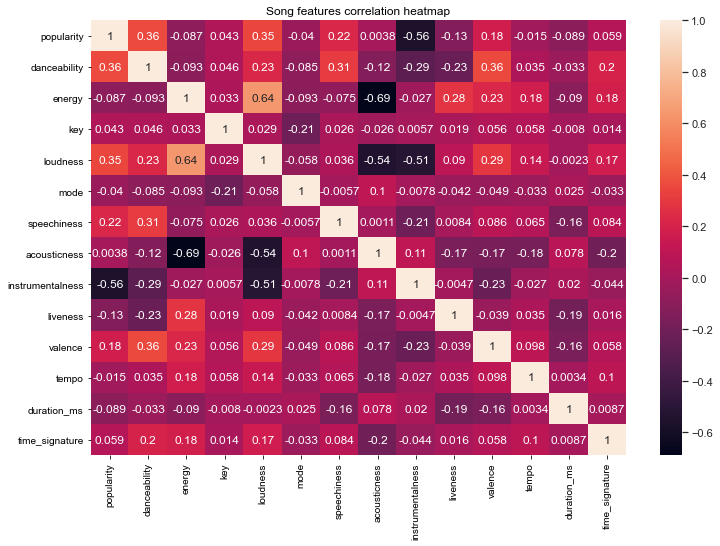

In [21]:
correlation = data[['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode','speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']].corr()

plt.figure(figsize=(12, 8))
plt.title('Song features correlation heatmap')
sns.set(style='darkgrid')
sns.heatmap(correlation, annot=True)

In [22]:
data[['artist', 'energy', 'acousticness']].groupby('artist').mean().sort_values(by='energy', ascending=False)

,energy,acousticness
artist,,
Saltwater,0.998000,0.000159
Robbie Seed,0.996000,0.000025
Kobaryo,0.996000,0.011200
Whitesnake,0.995000,0.001070
Sean Tyas,0.995000,0.000939
...,...,...
Cool Vibes Jazz,0.081800,0.790000
Brad Mehldau,0.045500,0.996000
Pete Yorn,0.042400,0.984000


In [23]:
data['acousticness'].mean()

0.20486048074642121

In [24]:
def plot_correlation(feature_1, feature_2, title):
    corr_df = data[[feature_1, feature_2]]
    corr_df['feature_1_interval'] = pd.cut(data[feature_1], np.arange(0,1,0.0001), 
    labels=[f"{feature_1}_{i}" for i in range(1,10000)])
    corr_df = corr_df.groupby("feature_1_interval").median()
    plot = px.scatter(corr_df,x=feature_1, y=feature_2,trendline="ols",trendline_color_override="red")
    plot.update_traces(marker=dict(size=5,color='rgba(30, 215, 96, .9)',
                                  line=dict(width=1)),
                      selector=dict(mode='markers'))
    plot.update_layout(title_text=title)
    plot.show()

In [28]:
plot_correlation('energy', 'loudness', 'Correlation')

<ipython-input-24-2de5210775a8>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# The most used keys and the most popular mode of the dataset

In [39]:
key_mapping = {
    0: 'C',
    1: 'C#',
    2: 'D',
    3: 'D#',
    4: 'E',
    5: 'F',
    6: 'F#',
    7: 'G',
    8: 'G#',
    9: 'A',
    10: 'A#',
    11: 'B',
}

key_count_df = pd.DataFrame(data['key'].value_counts())
key_count_df['key_name'] = key_count_df.index.to_series().map(key_mapping)

key_label = key_count_df['key_name'].values
key_value = key_count_df['key'].values

mode_mapping = {
    0:'Minor',
    1:'Major'
}

mode_count_df = pd.DataFrame(data['mode'].value_counts())
mode_count_df['mode_name'] = mode_count_df.index.to_series().map(mode_mapping)

mode_label = mode_count_df['mode_name'].values
mode_value = mode_count_df['mode'].values

fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'pie'}, {'type': 'pie'}]])

fig.add_trace(pgo.Pie(labels=key_label, values=key_value), row=1, col=1)
fig.add_trace(pgo.Pie(labels=mode_label, values=mode_value), row=1, col=2)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text='Key and Mode')
fig.show()